C:\WinPython\WPy64-3760\python-3.7.6.amd64\lib\site-packages\ipykernel_launcher.py:83: RuntimeWarning: divide by zero encountered in double_scalars


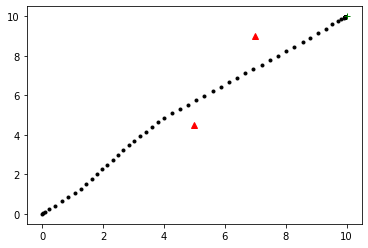

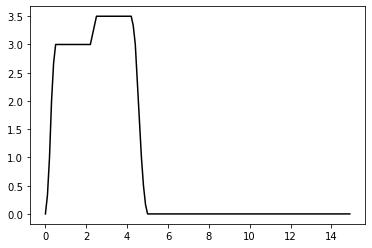

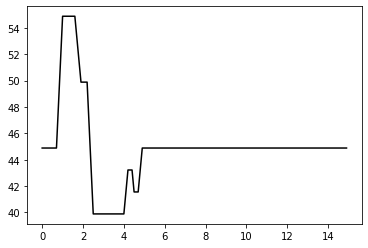

In [12]:
%reset -f

import numpy as np
import matplotlib.pyplot as plt
import math

PARAM_k_g = 2
PARAM_k_o = .3
PARAM_C_v = .3
PARAM_C_t = .3

LATERAL_OBSTACLE_CLEARANCE_DISTANCE = 1

START_TIME = 0 # s
END_TIME = 15 # s
TIME_STEP = 0.1 # s
TIME_STAMPS = np.arange(START_TIME, END_TIME, TIME_STEP)

SPEED_ACTIONS = np.array([-1, -0.5, 0, 0.5, 1]) # m/s
HEADING_ACTIONS = np.array([-10, -5, 0, 5, 10]) * math.pi/180 # rad

ACTION_DURATION = 0.3 # s
PREDICTION_TIME = ACTION_DURATION
ACTION_TIME_STEPS = math.ceil(ACTION_DURATION / TIME_STEP)
PREDICTION_TIME_STEPS = math.ceil(PREDICTION_TIME / TIME_STEP)

ACTIONS_VECTOR_LENGTH = TIME_STAMPS.size + PREDICTION_TIME_STEPS
accelerations = np.zeros(ACTIONS_VECTOR_LENGTH)
yaw_rates = np.zeros(ACTIONS_VECTOR_LENGTH)


X_O = np.array([[5, 4.5], [7, 9]])
N_OBSTACLES = X_O.shape[0]

X_G = np.array([10, 10])



def simulate(local_accelerations, local_yaw_rates, 
             i_curr_time_step, n_time_steps_to_advance):
    
    local_x = (x_history[i_curr_time_step, :])
    local_speed = (speed_history[i_curr_time_step])
    local_heading = (heading_history[i_curr_time_step])
    
    for i in range(i_curr_time_step + 1, i_curr_time_step + n_time_steps_to_advance + 1):
        local_speed += local_accelerations[i-1] * TIME_STEP
        local_heading += local_yaw_rates[i-1] * TIME_STEP
        local_x = local_x + TIME_STEP * local_speed \
            * np.array([math.cos(local_heading), math.sin(local_heading)])
    return (local_x, local_speed, local_heading)


def add_action(state_vector, action_magnitude, i_action_time_step):
    state_vector[i_action_time_step:i_action_time_step+ACTION_TIME_STEPS] += \
        action_magnitude / ACTION_DURATION;

    
def get_value_of_state(x, speed, heading, verbose = False):
    
    heading_vector = np.array([math.cos(heading), math.sin(heading)])
    
    vector_to_goal = X_G - x
    heading_to_goal_vector = vector_to_goal / np.linalg.norm(vector_to_goal)
    
    heading_toward_goal_component = np.dot(heading_vector, heading_to_goal_vector)
    goal_distance_change_rate = -heading_toward_goal_component * speed
    
    value = -PARAM_k_g * goal_distance_change_rate - PARAM_C_v * speed ** 2
    
    for i_obstacle in range(N_OBSTACLES):
        if N_OBSTACLES == 1:
            vector_to_obstacle = X_O - x
        else:
            vector_to_obstacle = X_O[i_obstacle,:] - x
        heading_to_obstacle_vector = vector_to_obstacle / np.linalg.norm(vector_to_obstacle)
        heading_toward_obstacle_component = np.dot(heading_vector, heading_to_obstacle_vector)
        angle_to_obstacle_rel_heading = math.acos(heading_toward_obstacle_component)
        lateral_distance_to_obstacle = np.linalg.norm(vector_to_obstacle) * math.sin(angle_to_obstacle_rel_heading)
        if lateral_distance_to_obstacle < LATERAL_OBSTACLE_CLEARANCE_DISTANCE \
            and heading_toward_obstacle_component > 0:
            long_distance_to_obstacle = np.linalg.norm(vector_to_obstacle) * math.cos(angle_to_obstacle_rel_heading)
            time_to_obstacle_collision = long_distance_to_obstacle / speed
            value += -PARAM_k_o / time_to_obstacle_collision
        #else:
        #    time_to_obstacle_collision = math.inf
    
        
    
    if verbose:
        #print(angle_to_obstacle_rel_heading * 180 / math.pi)
        #print(lateral_distance_to_obstacle, time_to_obstacle_collision)
        print(heading_toward_goal_component)
    
    return value


x_history = np.zeros((TIME_STAMPS.size, 2))
speed_history = np.zeros(TIME_STAMPS.shape) 
heading_history = np.zeros(TIME_STAMPS.shape)
heading_history[0] = math.pi/4.01 # rad



for i_time_step, time_stamp in enumerate(TIME_STAMPS):
    
    #get_value_of_state(x, speed, heading, verbose = True)
      
    # do Euler step
    if i_time_step > 0:
        (x_history[i_time_step, :], speed_history[i_time_step], heading_history[i_time_step]) = \
            simulate(accelerations, yaw_rates, i_time_step-1, 1)
        
    plt.plot(x_history[i_time_step, 0], x_history[i_time_step, 1], 'k.')
    
    # decide on action for this time step - by looping through the alternatives and getting predicted rewards
    best_value = -math.inf
    for i_speed_action, speed_action in enumerate(SPEED_ACTIONS):
        
        # make acceleration predictions
        if speed_action == 0:
            predicted_accelerations = accelerations
        else:
            predicted_accelerations = np.copy(accelerations)
            add_action(predicted_accelerations, speed_action, i_time_step)
        
        for i_heading_action, heading_action in enumerate(HEADING_ACTIONS):

            # make heading predictions
            if heading_action == 0:
                predicted_yaw_rates = yaw_rates
            else:
                predicted_yaw_rates = np.copy(yaw_rates)
                add_action(predicted_yaw_rates, heading_action, i_time_step)
            
            # get predicted state with this action combination
            (pred_x, pred_speed, pred_heading) = \
                simulate(predicted_accelerations, predicted_yaw_rates, \
                         i_time_step, PREDICTION_TIME_STEPS)    
                        
            # get value of the predicted state
            this_action_value = get_value_of_state(pred_x, pred_speed, pred_heading) \
                - PARAM_C_t * heading_action ** 2
            #print(pred_x, pred_speed, pred_heading, this_action_value)
                
            if this_action_value > best_value:
                best_value = this_action_value
                best_speed_action = speed_action
                best_heading_action = heading_action
    
    # execute the selected actions
    if best_speed_action != 0:
        #print('%.2f s (%.2f, %.2f): speed action %.2f' % \
        #      (time_stamp, x_history[i_time_step, 0], x_history[i_time_step, 1], best_speed_action))
        add_action(accelerations, best_speed_action, i_time_step)
    if best_heading_action != 0:
        #print('%.2f s (%.2f, %.2f): heading action %.2f' % \
        #      (time_stamp, x_history[i_time_step, 0], x_history[i_time_step, 1], best_heading_action * 180/math.pi))
        add_action(yaw_rates, best_heading_action, i_time_step)
    
    
            


for i_obstacle in range(N_OBSTACLES):
    plt.plot(X_O[i_obstacle,0], X_O[i_obstacle,1], 'r^')
plt.plot(X_G[0], X_G[1], 'g+')
plt.show()

plt.plot(TIME_STAMPS, speed_history, 'k-')
plt.show()

plt.plot(TIME_STAMPS, heading_history * 180 / math.pi, 'k-')
plt.show()




In [1]:
a = np.array([[5, 5], [7, 8]])
print(a[0, 1])
b = np.array([1, 2],)
print(b[:,0])

NameError: name 'np' is not defined

C:\GITHUB\COMMOTIONSFramework\one_agent.py:79: RuntimeWarning: divide by zero encountered in double_scalars
  if lateral_distance_to_obstacle < LATERAL_OBSTACLE_CLEARANCE_DISTANCE \


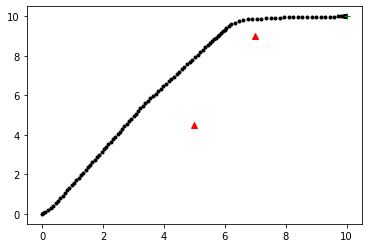

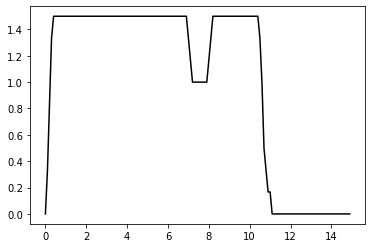

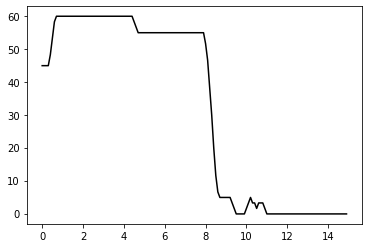

In [4]:
%run one_agent.py